In [1]:
import sys 
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
# sys.path.append('/users/jiajiaz/.conda/envs/mybrainiak/lib/python3.6/site-packages')
sys.path.append('../Multivariate_analyses_Daphne/')
import os 
import h5py
import glob
import time
import numpy as np
import pandas as pd 

from nilearn import datasets, image
from nilearn import surface
from nilearn import plotting
from nilearn import input_data

from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nibabel.affines import apply_affine
import nibabel as nib
import time

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
from brainiak.searchlight.searchlight import Searchlight
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import pandas as pd
from importlib import reload 
import scipy.io as sio
from scipy import stats
from numpy.linalg import inv

# import own functions
import utils
reload(utils)

sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

# Load data

In [2]:
BOLD_path = '/ncf/gershman/Lab/scripts/matlab/VGDL_fMRI/mat/'
path = './data/'
all_data = []
all_vol = []
all_df = []
all_tcf = []
all_tcfc = []
level_TRs = [-1]*54 # game i level j has index (i-1) * 9 + j-1
num_subj = 8

In [4]:
# Get the dataframe for each level of each game
for subj in range(num_subj):
    isc_df = []
    filename = 'BOLD_subj'+str(subj+1)+'_nosmooth.mat'
    data = h5py.File(BOLD_path+filename,'r')
    all_data.append(data)
    BOLD1 = pd.DataFrame(np.swapaxes(data['B'].value,1,0)) # store BOLD/residuals for subject
    game1 = pd.DataFrame(np.swapaxes(data['game'].value,1,0), columns=["game"]).shift(periods=3)
    level1 = pd.DataFrame(np.swapaxes(data['level'].value,1,0), columns=["level"]).shift(periods=3)
    tcf1 = pd.DataFrame(np.swapaxes(data['theory_change_flag'].value,1,0), columns=["tcf"]).shift(periods=3)
    tcfc1 = pd.DataFrame(np.swapaxes(data['theory_change_flag_cnt'].value,1,0), columns=["tcfc"]).shift(periods=3)
    df = pd.concat([BOLD1, game1, level1, tcf1, tcfc1], axis=1)
    
    for game_id in range(1,7):
        for level_id in range(1,10):
            level_TRs_idx = (game_id-1)*9+level_id-1
            # TODO change the below to have an array of df from raw data
            cur_df = df[(df['game']==game_id) & (df['level']==level_id)]
            cur_df = cur_df.reset_index(drop=True)
            isc_df.append(cur_df)
            print(cur_df.shape)
            if level_TRs[level_TRs_idx] == -1 or level_TRs[level_TRs_idx] > cur_df.shape[0]:
                level_TRs[level_TRs_idx] = cur_df.shape[0]
    all_df.append(isc_df)

(30, 179599)
(28, 179599)
(28, 179599)
(26, 179599)
(26, 179599)
(29, 179599)
(27, 179599)
(27, 179599)
(28, 179599)
(28, 179599)
(28, 179599)
(28, 179599)
(26, 179599)
(27, 179599)
(27, 179599)
(27, 179599)
(27, 179599)
(27, 179599)
(27, 179599)
(30, 179599)
(27, 179599)
(28, 179599)
(27, 179599)
(27, 179599)
(27, 179599)
(29, 179599)
(25, 179599)
(27, 179599)
(28, 179599)
(29, 179599)
(28, 179599)
(28, 179599)
(27, 179599)
(26, 179599)
(27, 179599)
(27, 179599)
(28, 179599)
(28, 179599)
(29, 179599)
(27, 179599)
(28, 179599)
(26, 179599)
(27, 179599)
(27, 179599)
(28, 179599)
(29, 179599)
(26, 179599)
(28, 179599)
(28, 179599)
(28, 179599)
(27, 179599)
(27, 179599)
(25, 179599)
(29, 179599)
(27, 179599)
(31, 179599)
(27, 179599)
(27, 179599)
(26, 179599)
(26, 179599)
(28, 179599)
(25, 179599)
(28, 179599)
(25, 179599)
(28, 179599)
(29, 179599)
(27, 179599)
(26, 179599)
(27, 179599)
(27, 179599)
(27, 179599)
(25, 179599)
(27, 179599)
(28, 179599)
(28, 179599)
(29, 179599)
(26, 179599)

In [6]:
print(all_df[1][0])

            0           1           2           3           4           5  \
0   88.866012   96.972791  103.003787  105.893054  105.079571  100.731644   
1   87.996427   94.560393   99.132729  101.404872  101.012156   97.617968   
2   88.641603   95.177518   99.581547  101.601230  101.152411   98.066786   
3   89.875853   97.365507  102.639122  104.686855  103.087940   98.178990   
4   90.436876   97.225252  101.797588  103.901423  103.396502  100.170621   
5   87.519557   94.616496   99.553496  101.432923  100.142570   96.243462   
6   91.502819   99.048576  104.350241  106.734588  105.724747  101.432923   
7   88.108631   95.177518  100.395031  103.003787  102.554968   99.076627   
8   86.678023   92.905376   97.561865  100.675542  101.685383   99.777905   
9   92.344353   99.749854  104.742957  106.510179  104.827111  100.114519   
10  88.361091   95.177518   99.974263  102.526917  102.667173  100.198673   
11  90.549080   98.291195  103.789218  105.921105  104.322190   99.553496   

In [8]:
# Save the results! Now all levels across all subjects should have the same shape
for subj in range(num_subj):
    isc_df = all_df[subj]
    for game_id in range(1,7):
        for level_id in range(1,10):
            level_TRs_idx = (game_id-1)*9+level_id-1
            isc_df[level_TRs_idx].to_pickle(path+str(subj)+'_'+str(game_id)+'_'+str(level_id)+'.pkl')
np.save(path+'level_TRs', level_TRs)

# Load data back from these files
# all_df = []
# for subj in range(num_subj):
#     isc_df = []
#     for game_id in range(1,7):
#         for level_id in range(1,10):
#             isc_df.append(pd.read_pickle(path+str(subj)+'_'+str(game_id)+'_'+str(level_id)+'.pkl'))
#     all_df.append(isc_df)
# level_TRs = np.load(path+'level_TRs.npy')

In [ ]:
all_tcfc = pd.DataFrame(np.load(path+'all_tcfc.npy')).transpose()
num_fakes = 10000
excluded_TRs = []
for game_id in range(6):
    begin = sum(level_TRs[:game_id*9])
    end = sum(level_TRs[:game_id*9+9])
    excluded_TRs += list(range(begin, begin+3)) + list(range(end-3,end))
all_tcfc.loc[excluded_TRs, :] = 0

all_real_and_fake = [all_tcfc]
for subj in range(num_subj):
    print(subj)
    freqs = all_tcfc.drop(subj, axis=1).eq(1).sum(axis = 1)/(num_subj-1)
    fake_tcfs = []
    for i in range(num_fakes):
        fake_tcf = pd.Series([0]*sum(level_TRs))
        for TR in range(sum(level_TRs)):
            if TR not in excluded_TRs:
                fake_tcf[TR] = np.random.choice([0,1], p=[1-freqs.loc[TR],freqs.loc[TR]])
        fake_tcfs.append(fake_tcf)
    leave_out_tcf = pd.concat(fake_tcfs,axis=1)
    all_real_and_fake.append(leave_out_tcf)

# Save the real+fake zero-ed out theory change flags
all_real_and_fake.to_pickle(path+'all_real_and_fake.pkl')

0
1
2
3
4


In [7]:
# Now we reshape the data. Each level is a dataframe. 
# After reshaping, for each level, there should be the same TRs across all subjects
for subj in range(num_subj):
    isc_df = all_df[subj]
    print('before', subj, all_df[subj][0].shape)
    for game_id in range(1,7):
        for level_id in range(1,10):
            level_TRs_idx = (game_id-1)*9+level_id-1
            isc_df[level_TRs_idx] = isc_df[level_TRs_idx].truncate(after=(level_TRs[level_TRs_idx]-1))
    all_df[subj] = isc_df
    print('after',subj, all_df[subj][0].shape)

before 0 (27, 179599)
after 0 (27, 179599)
before 1 (27, 179599)
after 1 (27, 179599)
before 2 (27, 179599)
after 2 (27, 179599)
before 3 (27, 179599)
after 3 (27, 179599)
before 4 (27, 179599)
after 4 (27, 179599)
before 5 (27, 179599)
after 5 (27, 179599)
before 6 (27, 179599)
after 6 (27, 179599)
before 7 (27, 179599)
after 7 (27, 179599)


## Reshape data into 4D volumes. Fill in NaN values for tcf and tcfc

In [5]:
# mask_nii is the functional mask, this selects the brain voxels
mask_nii_NS = nib.load(os.path.join(path, 'mask_nosmooth.nii')) 
mask_nii = nib.load(os.path.join(path, 'mask.nii')) 
print(mask_nii.shape)
# inverse of the affine matrix: mni2cor
inv_affine = inv(mask_nii_NS.affine) # get the transformation matrix

# load mask and get voxel coordinates
# mask_arr = np.load(path+'mask_arr.npy') 
filename = 'BOLD_subj1_nosmooth.mat'
data = h5py.File(BOLD_path+filename,'r')
mask_mat = data['mask'].value
coords_mat = np.array(np.where(mask_mat == 1)) # so need one set of voxel coordinates for all
coords_mat[[0, 2]] = coords_mat[[2, 0]] # exchange the rows

# residuals
# R = np.load(path+'residuals_sub1.npy')
# R = np.swapaxes(R,1,0)

num_TR = sum(level_TRs)
print(num_TR)
vol4D = mask_nii.shape+(num_TR,)
coords = tuple(coords_mat)
num_voxel = len(np.where(mask_nii_NS.dataobj)[0])
# for subj in range(num_subj):
#     all_vol.append(np.zeros(vol4D))


1402


In [9]:

pd.concat(all_df[0],axis=0).head(100)

,0,1,2,3,4,5,6,7,8,9,...,179589,179590,179591,179592,179593,179594,game,level,tcf,tcfc
0,72.472996,75.539245,78.298870,80.270030,80.708066,78.999727,75.561147,77.488504,79.021628,80.598557,...,161.372328,146.829545,140.171403,189.319001,213.367157,220.112906,1.0,1.0,1.0,2.0
1,78.320771,83.292476,87.388109,89.600189,89.162153,85.811181,79.043530,82.613521,85.635966,88.242279,...,160.299140,143.500474,136.732823,191.246358,213.367157,219.412049,1.0,1.0,1.0,2.0
2,74.663174,77.817030,80.401441,82.175485,82.438306,80.423342,76.984763,79.459664,81.124199,82.482110,...,160.627667,145.033598,137.959323,189.822742,214.265130,219.061621,1.0,1.0,0.0,0.0
3,74.925995,78.780709,81.956467,83.905726,83.796217,80.992789,76.656236,79.634878,81.890762,83.796217,...,158.875525,144.179429,137.893618,189.297099,211.658818,215.973469,1.0,1.0,1.0,1.0
4,75.210718,80.708066,85.241734,87.694734,87.147189,83.314378,74.794585,79.174941,83.117262,86.358725,...,159.904908,143.741393,137.192761,191.969117,213.761390,218.119844,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,78.921802,82.282034,85.271330,87.387840,87.758775,85.533167,80.863754,83.111182,84.769478,86.427774,...,147.522893,137.376739,131.899998,215.403934,221.491626,199.126449,1.0,4.0,0.0,0.0
14,80.732836,85.358609,88.980677,90.857170,90.311678,86.973266,82.085656,85.620445,88.500644,90.769891,...,147.501073,138.576822,133.340097,218.131395,219.811511,198.144563,1.0,4.0,0.0,0.0
15,81.649263,85.925921,89.482530,91.533580,91.359023,88.369726,82.543870,85.795003,88.347906,90.464416,...,148.046565,138.162248,132.729146,220.357003,223.739054,198.733694,1.0,4.0,0.0,0.0
16,80.361901,84.573101,88.391545,90.835350,90.922629,87.998791,82.652968,85.140412,87.409660,89.635268,...,146.410089,139.798724,134.496541,206.261486,220.247904,196.268070,1.0,4.0,0.0,0.0


In [23]:
for subj in range(num_subj):
    isc_vol = all_vol[subj]
    isc_df = pd.concat(all_df[subj],axis=0)
    isc_df = isc_df.reset_index(drop=True)
    isc_df['tcf'] = isc_df['tcf'].fillna(value=0)
    isc_df['tcfc'] = isc_df['tcfc'].fillna(value=0)
    start = time.time()
    for TR in range(num_TR):
        for j in range(num_voxel):
            isc_vol[(coords[0][j], coords[1][j], coords[2][j], TR)] = isc_df.loc[TR, j]
    all_tcfc.append(isc_df['tcfc'])
    all_tcf.append(isc_df['tcf'])
    all_df[subj] = isc_df 
    all_vol[subj] = isc_vol
    print(time.time() - start)

1962.5010056495667
1960.7240498065948
1967.392011165619
1964.0317153930664
1965.660180568695
1960.4632215499878
1975.369684457779
1958.9528665542603


In [36]:
# Save the complete data for each subj
for subj in range(num_subj):
    np.save(path+'vol'+str(subj), all_vol[subj])
np.save(path+'all_tcfc',all_tcfc)
np.save(path+'all_tcf',all_tcf)

# Load the volume data 4D
# all_vol = []
# for subj in range(4):
#     all_vol.append(np.load(path+'vol'+str(subj)+'.npy'))
# for subj in range(4,num_subj):
#     all_vol.append(np.load(path+'vol'+str(subj)+'.npy'))
# all_tcfc = np.load(path+'all_tcfc.npy')
# all_tcf = np.load(path+'all_tcf.npy')

In [6]:
all_vol[0].shape

(79, 95, 79, 1402)

In [27]:
# Save the complete data for each subj
for subj in range(num_subj):
    all_df[subj].to_pickle(path+'all'+str(subj)+'.pkl')

# Load complete data
# all_df = []
# for subj in range(num_subj):
#     all_df.append(pd.read_pickle(path+'all'+str(subj)+'.pkl'))

In [222]:
# Make fake tcfs
# all_tcf = pd.DataFrame(all_tcf).transpose()
# num_fakes = 1000
# # all_flags = pd.concat(all_tcf,axis=1)
# freqs = all_tcf.sum(axis = 1)/num_subj
# for i in range(num_fakes):
#     fake_tcf = pd.Series([0]*num_TR)
#     for TR in range(num_TR):
#         fake_tcf[TR] = np.random.choice([0,1], p=[1-freqs.loc[TR],freqs.loc[TR]])
#     all_tcf = pd.concat([all_tcf,fake_tcf],axis=1)
    

# all_tcf = all_tcf.transpose().reset_index(drop=True).transpose()

In [13]:
all_tcf.shape

(8, 1402)

In [7]:
print(all_vol[0].shape)
print(np.array(all_tcfc[0]))
print(all_tcf[0][all_tcf[0] > 0].index.values)
for subj in range(num_subj):
    print(all_tcfc[subj].shape)
print(all_tcf.shape)

(79, 95, 79, 1402)
[2. 2. 0. ... 0. 0. 0.]


AttributeError: 'numpy.ndarray' object has no attribute 'index'

# Translate from MNI space for searchlight

In [7]:
# theory ROIs (model-based), encoding theory
# all MNI coordinates!
R_IFG_Tri = [42, 28, 26]
L_Insula = [-30, 28, 2]
R_DMPFC = [6, 38, 40]
L_IFG_Tri = [-50, 44, 12]
L_MTG = [-64, -50, 4]
R_MTG = [58, -36, 8]

# Theory_change_flag ROIs, updating theory
R_IFG_Oper_U = [48, 12, 28]
L_PPC_U = [-56, -32, 46]
R_IFG_Tri_U = [52, 38, 16]
R_AG_U = [32, -60, 34]
L_Fusiform_U = [-40, -58, -12]
L_IFG_Oper_U = [-42, 4, 28]
R_PHC_U = [26, -42, -8]

# create dictionary to map points to roi names
roi_dict = {'right inferior frontal gyrus (Tri)':R_IFG_Tri, 'left_insula':L_Insula, 'right dorsalmedial PFC':R_DMPFC,
            'left inferior frontal gyrus (Tri)':L_IFG_Tri, 'left middle temporal gyrus':L_MTG, 'right middle temporal gyrus':R_MTG
           }

brain_mask = np.array(mask_nii.dataobj)
roi_mask = np.zeros(brain_mask.shape)
print(roi_mask[roi_mask==1].shape)
native_roi_coords = []
for mni_coords in roi_dict:
    native_coords = apply_affine(aff=inv_affine, pts=roi_dict[mni_coords]).astype(int) # from mni2cor
#     native_roi_coords += native_coords.astype(int)
    roi_mask[tuple(native_coords)] = 1
print(roi_mask[roi_mask==1].shape)

(0,)
(6,)


# Using searchlight to get an r value for each region

In [ ]:
# Preset the variables
data = all_vol
mask = roi_mask
bcvar = all_tcfc
sl_rad = 8
max_blk_edge = 5
pool_size = 1
# Create the searchlight object
sl = Searchlight(sl_rad=sl_rad,max_blk_edge=max_blk_edge)
print("Setup searchlight inputs")
print("Number of subjects: " + str(len(data)))
print("Input data shape: " + str(data[0].shape))
print("Input mask shape: " + str(mask.shape) + "\n")

# Distribute the information to the searchlights (preparing it to run)
sl.distribute(data, mask)
# Data that is needed for all searchlights is sent to all cores via the sl.broadcast function. 
sl.broadcast(bcvar)

Setup searchlight inputs
Number of subjects: 8
Input data shape: (79, 95, 79, 1402)
Input mask shape: (79, 95, 79)



In [ ]:
a = pd.DataFrame(all_tcf).transpose()
a[1]

In [9]:
# Set up the kernel
def avg_corr(data, sl_mask, myrad, bcvar):
    all_r = []
    all_tcf = bcvar
    all_tcf = pd.DataFrame(all_tcf).transpose()
    num_subj= len(data)
    num_TR = all_tcf.shape[0]
    # Loop over subject: 
    # TODO focus on subject 0 for now
    for subj in range(num_subj):
        # Make fake tcfs
        leave_out_tcf = all_tcf.drop(subj, axis=1)
        num_fakes = 10000
        # all_flags = pd.concat(all_tcf,axis=1)
        freqs = leave_out_tcf.sum(axis = 1)/num_subj
        for i in range(num_fakes):
            fake_tcf = pd.Series([0]*num_TR)
            for TR in range(num_TR):
                fake_tcf[TR] = np.random.choice([0,1], p=[1-freqs.loc[TR],freqs.loc[TR]])
            leave_out_tcf = pd.concat([leave_out_tcf,fake_tcf],axis=1)
        leave_out_tcf = pd.concat([all_tcf[subj], leave_out_tcf], axis=1)

        leave_out_tcf = leave_out_tcf.transpose().reset_index(drop=True).transpose()
        subj_r = []
        data4D = data[subj]
        bolddata_sl = data4D.reshape(sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2], data[0].shape[3]).T
        # first col is the subj real tcf, and the rest are fake ones
#         tcf_cols = [*range(num_subj, all_tcf.shape[1])]
        for idx in range(num_fakes+1):
            tcf = leave_out_tcf[idx][leave_out_tcf[idx] > 0].index.values
            tcf_r = []
            for flag_idx in tcf:
                # Ignore the first 3 TRs
                # And Ignore flags at the end
                if flag_idx >= 3 and flag_idx < num_TR-3:
                    before_idx = flag_idx - 3
                    after_idx = flag_idx + 3
                    flag_r = np.corrcoef(bolddata_sl[before_idx], bolddata_sl[after_idx])
                    tcf_r.append(flag_r)
            subj_r.append(np.mean(tcf_r))
        all_r.append(subj_r)
            
    return all_r

In [ ]:
# Another kernel option
def tcfc(data, sl_mask, myrad, bcvar):
    all_r = []
    all_tcf = bcvar
    all_tcf = pd.DataFrame(all_tcf).transpose()
    num_subj= len(data)
    num_TR = all_tcf.shape[0]
    # Loop over subject: 
    # TODO focus on subject 0 for now
    for subj in range(num_subj):
        # Make fake tcfs
        leave_out_tcf = all_tcf.drop(subj, axis=1)
        num_fakes = 0
        # all_flags = pd.concat(all_tcf,axis=1)
        freqs = leave_out_tcf.eq(1).sum(axis = 1)/num_subj
        for i in range(num_fakes):
            fake_tcf = pd.Series([0]*num_TR)
            for TR in range(num_TR):
                fake_tcf[TR] = np.random.choice([0,1], p=[1-freqs.loc[TR],freqs.loc[TR]])
            leave_out_tcf = pd.concat([leave_out_tcf,fake_tcf],axis=1)
        leave_out_tcf = pd.concat([all_tcf[subj], leave_out_tcf], axis=1)

        leave_out_tcf = leave_out_tcf.transpose().reset_index(drop=True).transpose()
        subj_r = []
        data4D = data[subj]
        bolddata_sl = data4D.reshape(sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2], data[0].shape[3]).T
        # first col is the subj real tcf, and the rest are fake ones
#         tcf_cols = [*range(num_subj, all_tcf.shape[1])]
        for idx in range(num_fakes+1):
            tcf = leave_out_tcf[idx][leave_out_tcf[idx] > 0].index.values
            tcf_r = []
            for flag_idx in tcf:
                # Ignore the first 3 TRs
                # And Ignore flags at the end
                if flag_idx >= 3 and flag_idx < num_TR-3:
                    before_idx = flag_idx - 3
                    after_idx = flag_idx + 3
                    flag_r = np.corrcoef(bolddata_sl[before_idx], bolddata_sl[after_idx])
                    tcf_r.append(flag_r)
            subj_r.append(np.mean(tcf_r))
        all_r.append(subj_r)
            
    return all_r

In [10]:
# Execute searchlight on 8 subjects
print("Begin Searchlight\n")
sl_result_allsubj = sl.run_searchlight(avg_corr, pool_size=pool_size)
print("End Searchlight\n")
print([i for i in sl_result_allsubj[mask==1]])

Begin Searchlight

End Searchlight

[[[0.9999767109662813, 0.9999793237820397, 0.9999761781545, 0.9999761942749523, 0.9999761083718107, 0.9999739464355204, 0.9999727844639702, 0.9999747124124869, 0.9999725130508254, 0.9999768251264111, 0.9999762804148409, 0.9999744084108593, 0.999975978548089, 0.9999737151664249, 0.9999767632443932, 0.999977079746391, 0.9999731648150572, 0.999976379896567, 0.9999756348649415, 0.9999787675960703, 0.9999784983589544, 0.9999744498020943, 0.9999761444606533, 0.9999771779188285, 0.9999773263019401, 0.9999760613335873, 0.999973078349093, 0.9999726287505888, 0.9999769710073301, 0.999973441723457, 0.9999762755409723, 0.9999739274985674, 0.999975949877645, 0.9999734846754688, 0.9999761918681987, 0.9999770795579954, 0.9999751981777528, 0.9999749575123397, 0.9999728035270958, 0.9999727983806205, 0.99997582949597, 0.9999773628942706, 0.999976789806871, 0.9999801665779062, 0.9999766741402856, 0.9999717392162031, 0.9999763231887071, 0.999972470411794, 0.999974351120

In [11]:
print(len(sl_result_allsubj[mask==1]))
print(len(sl_result_allsubj[mask==1][0]))
print(len(sl_result_allsubj[mask==1][0][0]))

6
8
1001


# Results (t-test)

In [35]:
# sl_result_allsubj[mask==1][region][subj][tcf_idx])
for region in range(len(roi_dict)):
    print("region",region)
    for subj in range(num_subj):
        print("    Subj ",subj)
        print("    ",sl_result_allsubj[mask==1][region][subj][0])
    #     plt.hist(sl_result_allsubj[mask==1][0][0][1:])
        tstats,p = stats.ttest_1samp(sl_result_allsubj[mask==1][region][subj][1:], popmean=sl_result_allsubj[mask==1][region][subj][0])
        print("    ",tstats, p)

region 0
    Subj  0
     0.9999767109662813
     -19.512108398475252 4.3402315672199737e-72
    Subj  1
     0.9999774168050305
     -29.51686920284122 3.4436991984940994e-138
    Subj  2
     0.9999726259348679
     -10.925826395068489 2.5010088403240468e-26
    Subj  3
     0.9999795748561161
     -61.15856049886012 0.0
    Subj  4
     0.9999596718990945
     0.1598685267264585 0.8730169587426058
    Subj  5
     0.999956003899502
     52.51856158734887 1.2802282084854032e-289
    Subj  6
     0.9999789833465061
     32.792238456277545 1.113515144308886e-160
    Subj  7
     0.9999793096331763
     -0.3628496937593394 0.7167939228503345
region 1
    Subj  0
     0.9999723030528873
     -21.46464704340645 2.3999213661404187e-84
    Subj  1
     0.9999670119241167
     -39.06250810377061 2.3706937624706773e-203
    Subj  2
     0.9999512420409766
     -5.563160800054844 3.401496627773748e-08
    Subj  3
     0.9999634052528384
     -45.22274224129072 6.077122107400949e-244
    Subj  

TypeError: 'NoneType' object is not subscriptable

0.9999774168050305


(array([ 10.,  45., 140., 206., 234., 184., 110.,  53.,  16.,   2.]),
 array([0.99997308, 0.9999738 , 0.99997452, 0.99997524, 0.99997596,
        0.99997668, 0.9999774 , 0.99997812, 0.99997884, 0.99997956,
        0.99998028]),
 <a list of 10 Patch objects>)

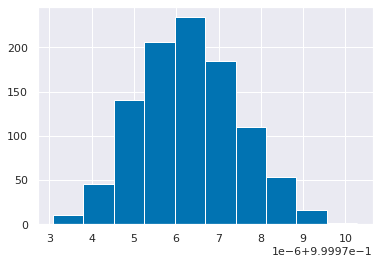

In [13]:
print(sl_result_allsubj[mask==1][0][1][0])
plt.hist(sl_result_allsubj[mask==1][0][1][1:])

0.9999726259348679


(array([ 11.,  53., 145., 233., 269., 183.,  72.,  31.,   2.,   1.]),
 array([0.99996416, 0.99996596, 0.99996775, 0.99996955, 0.99997135,
        0.99997315, 0.99997495, 0.99997675, 0.99997855, 0.99998034,
        0.99998214]),
 <a list of 10 Patch objects>)

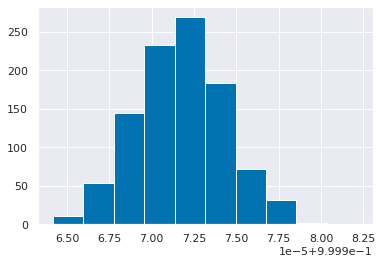

In [14]:
print(sl_result_allsubj[mask==1][0][2][0])
plt.hist(sl_result_allsubj[mask==1][0][2][1:])

0.9999795748561161


(array([  3.,  12.,  32.,  78., 171., 282., 234., 139.,  43.,   6.]),
 array([0.99997017, 0.99997128, 0.99997238, 0.99997348, 0.99997458,
        0.99997569, 0.99997679, 0.99997789, 0.99997899, 0.99998009,
        0.9999812 ]),
 <a list of 10 Patch objects>)

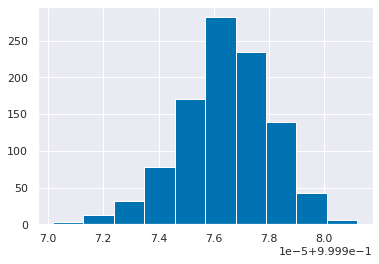

In [15]:
print(sl_result_allsubj[mask==1][0][3][0])
plt.hist(sl_result_allsubj[mask==1][0][3][1:])

0.9999596718990945


(array([ 10.,  38.,  74., 148., 195., 183., 175., 105.,  51.,  21.]),
 array([0.99994662, 0.99994913, 0.99995165, 0.99995417, 0.99995669,
        0.99995921, 0.99996172, 0.99996424, 0.99996676, 0.99996928,
        0.9999718 ]),
 <a list of 10 Patch objects>)

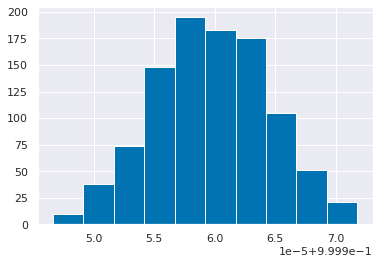

In [16]:
print(sl_result_allsubj[mask==1][0][4][0])
plt.hist(sl_result_allsubj[mask==1][0][4][1:])

0.999956003899502


(array([  9.,  34.,  73., 153., 215., 206., 169.,  90.,  35.,  16.]),
 array([0.99995338, 0.9999546 , 0.99995581, 0.99995703, 0.99995825,
        0.99995947, 0.99996069, 0.99996191, 0.99996313, 0.99996435,
        0.99996556]),
 <a list of 10 Patch objects>)

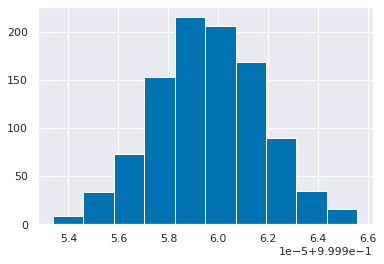

In [17]:
print(sl_result_allsubj[mask==1][0][5][0])
plt.hist(sl_result_allsubj[mask==1][0][5][1:])

0.9999789833465061


(array([  8.,  15.,  50., 125., 235., 238., 195.,  88.,  36.,  10.]),
 array([0.99997685, 0.99997744, 0.99997803, 0.99997861, 0.9999792 ,
        0.99997979, 0.99998038, 0.99998097, 0.99998155, 0.99998214,
        0.99998273]),
 <a list of 10 Patch objects>)

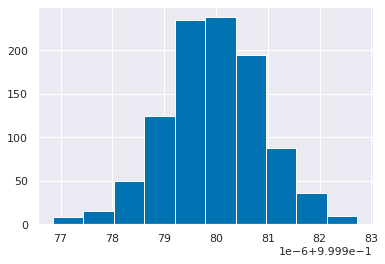

In [18]:
print(sl_result_allsubj[mask==1][0][6][0])
plt.hist(sl_result_allsubj[mask==1][0][6][1:])

0.9999793096331763


(array([  2.,  20.,  35., 100., 202., 246., 227., 120.,  41.,   7.]),
 array([0.9999731 , 0.99997422, 0.99997534, 0.99997646, 0.99997758,
        0.99997871, 0.99997983, 0.99998095, 0.99998207, 0.99998319,
        0.99998431]),
 <a list of 10 Patch objects>)

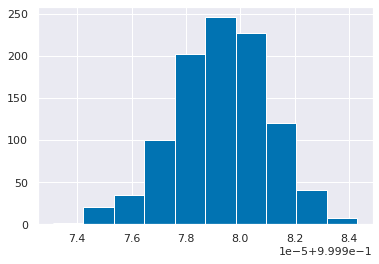

In [19]:
print(sl_result_allsubj[mask==1][0][7][0])
plt.hist(sl_result_allsubj[mask==1][0][7][1:])